In [1]:
import os
from typing import TypedDict, Annotated, Literal, List, Any
from dotenv import load_dotenv
from langchain.agents import create_agent
from langchain.agents.middleware import after_model
# from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, AIMessage, ToolMessage
from langchain.tools import tool, ToolRuntime
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import Command, interrupt
from langchain_core.prompts import ChatPromptTemplate
# from langgraph.runtime import Runtime
from langgraph.graph import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_core.stores import InMemoryStore
# from langchain_ollama import ChatOllama
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools import DuckDuckGoSearchRun
from pydantic import BaseModel, Field

In [2]:
class RLAgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    user_input: str
    steps: str
    reasoning: str
    changes: list[str]
    first_response: str
    current_response: str
    final_response: str
    jump_to: str
    content: list[Any]
    insights: str
    first_run: bool
    approved: bool
    counter: int
    max_loop: int

In [3]:
store = InMemoryStore()
user_id = '1'
namespace = (user_id, 'insights')

In [4]:
model = ChatGoogleGenerativeAI(
    model='gemini-2.5-flash',
    temperature=0.2,
    api_key=os.getenv('GOOGLE_API_KEY')
)

In [5]:
search = DuckDuckGoSearchRun()
# search.invoke("Obama's first name?")

In [6]:
tools = [search]

In [7]:
search_agent = create_agent(model=model, tools=tools, state_schema=RLAgentState)

In [8]:
model_with_tools = model.bind_tools(tools)

In [9]:
class Reasoning(BaseModel):
    steps: str = Field(description='All the planned steps in order', min_length=1)
    reasoning: str = Field(description='Reasoning and thought process', min_length=1)

class Research(BaseModel):
    target_age_group: Literal['18 and below','18-45','45 and above']
    target_gender: Literal['Male','Female', 'Non-Binary', 'Everyone']
    target_persona: str = Field(description='Persona of people who might be interested in this', min_length=1)
    research_reasoning: str = Field(description='Reasoning for selecting the target demographics', min_length=1)

class Insights(BaseModel):
    insights: str = Field(description='Insights created')

In [10]:
reasoning_prompt = ChatPromptTemplate.from_template(
    """
    You are given a user input {input}. Your job is to plan your steps and mention your reasoning/ thought process behind your planning. You have these tools: {tools},
    In your reasoning mention your indepth thought process and explanations as to why you think this is the correct approach.
    """
)
reasoning_chain = reasoning_prompt | model.with_structured_output(Reasoning)

reasoning_with_insights_prompt = ChatPromptTemplate.from_template(
    """
    You are given a user input: {input} and insights from previous runs: {insights}. Your job is to plan your steps for tackling the query and mention your reasoning or thought process behind your planning for each step. You have these tools: {tools}.
    In your reasoning mention your indepth thought process and explanations as to why you think this is the correct approach.
    """
)
reasoning_with_insights_chain = reasoning_with_insights_prompt | model.with_structured_output(Reasoning)

In [11]:
@tool
def search_browser(query : str | None, runtime: ToolRuntime[None | RLAgentState]) -> Command:
    """
    This tool calls another agent who search the web to find results
    :param query: str
    :return: Command
    """
    print('\nEntering search browser tool.....')
    messages = runtime.state['messages']
    # tool_call_id = state['messages'][-1].tool_calls[-1]['id']

    res = search_agent.invoke({
        'messages': [SystemMessage(content='You are an agent who can use search tools to find the most relevant texts based on the user queries from the web')] + messages,
    })

    # res = search_agent.invoke({
    #     'messages': SystemMessage(content='You are an agent who can use search tools to fnd the most relevant texts based on the user queries from the web') + HumanMessage(content=query),
    # })

    return Command(update=
        {
            'messages': [ToolMessage(content=res['messages'][-1].content, tool_call_id=runtime.tool_call_id)]
        }
    )
@tool
def create_research(runtime: ToolRuntime[None | RLAgentState]) -> Command:
    """
    This tool calls another agent who creates a research based on all the gathered information from tools
    :return: Command
    """
    print('\nEntering Research tool.....')
    messages = runtime.state['messages']

    system_message = SystemMessage(content='You are an agent that conducts research based on the provided information from web search and responds in a structured way')

    res = model.with_structured_output(Research).invoke([system_message]+messages)
    out_message = f"""
    The Research conducted is as follows:
    The Target Age group is {res.target_age_group},
    The Target Gender is {res.target_gender},
    The Target Persona who is interested is {res.target_persona},
    The why: {res.research_reasoning}
    """

    if runtime.state['first_run']:

        return Command(update=
            {
                'messages' : [ToolMessage(content=out_message, tool_call_id=runtime.tool_call_id)],
                'first_run': False,
                'first_response': out_message,
                'current_response': out_message,
                'content': [res.target_age_group,res.target_gender,res.target_persona, res.research_reasoning]
            }
        )

    else:
        return Command(update=
            {
                'messages' : [ToolMessage(content=out_message, tool_call_id=runtime.tool_call_id)],
                'current_response': out_message,
                'content': [res.target_age_group,res.target_gender,res.target_persona, res.research_reasoning]
            }
        )


In [12]:
# def convert_to_google_messages(messages):
#     new_messages = []
#     for message in messages:
#         if isinstance(message, SystemMessage):
#             new_message = {
#                 'role': 'system',
#                 'content': message.content
#             }
#         elif isinstance(message, HumanMessage):
#             new_message

#         new_messages.append(new_message)

In [13]:
tool_agents = [search_browser, create_research]

def planning_reasoning_step(state: RLAgentState):
    print('\nEntering Planning Reasoning Node.......')
    if state['first_run']:
        print('Without Insights..')
        res = reasoning_chain.invoke(
            {
                'input' : state['user_input'],
                'tools' : tools+tool_agents,
            }
        )

        return {
            'messages' : AIMessage(content='The Plan is as follows : ' + res.steps + '\n\n' +
                                           'The reasoning for them is as follows : ' + res.reasoning),
            'reasoning' : res.reasoning,
            'steps': res.steps,
        }

    else:
        print('With Insights..')
        res = reasoning_with_insights_chain.invoke(
            {
                'input' : state['user_input'],
                'insights': state['insights'],
                'tools' : tools+tool_agents,
            }
        )

        return {
            'messages' : AIMessage(content='The Plan is as follows : ' + res.steps + '\n\n' +
                                           'The reasoning for them is as follows : ' + res.reasoning),
            'reasoning' : res.reasoning,
            'steps' : res.steps,
        }


def router(state: RLAgentState):
    print('\nEntering Router .....')

    try:
        changes = state['changes']
        print('Router with user changes called....')
        messages = state['messages'] + [AIMessage(content='These changes have been asked by the User {changes}. Incorporate them and change your research')]

        messages = state['messages']
        if len(messages) > 5:
            messages = messages[1:]
        # parsed_messages = convert_to_google_messages(messages)

        res = model.bind_tools(tool_agents).invoke(messages)
        try:
            print(f'\nTool called: {res.tool_calls[0]['name']}')
        except:
            print('\nNo tool called')
        return {
            'messages' : res
        }
    except:

        messages = state['messages']
        if len(messages) > 5:
            messages = messages[1:]
        # parsed_messages = convert_to_google_messages(messages)

        res = model.bind_tools(tool_agents).invoke(messages)
        try:
            print(f'\nTool called: {res.tool_calls[0]['name']}')
        except:
            print('\nNo tool called')
        return {
            'messages' : res
        }

def which_agent(state: RLAgentState)->Literal['search_agent',END]:

    last_message = state['messages'][-1]
    if len(last_message.tool_calls)>0:
        tool = last_message.tool_calls[0]['name']
        if tool == 'search_browser':
            return 'search_agent'
        elif tool == 'create_research':
            return 'research_agent'
        else:
            return END

    else:
        return END

def hitl(state: RLAgentState):

    if state['approved'] or 'approved' not in state:
        print('\nEntering HITL last time.....')
        return {
            'messages' : state['messages'],
        }

    else:
        print('\nEntering HITL.......')
        output = [state['reasoning'], state['current_response'], state['content']]
        changes = interrupt(
            output
        )

        print('Human Feedback:  ', changes)
        if changes == 'Approved':
            return {
                'messages': AIMessage(content='No changes needed. Proceed to Finalise Research'),
                'final_response': state['current_response'],
                'jump_to': 'END',
                'approved': True
            }

        else:
            return {
                'messages': AIMessage(content=f'Changes added. Refer the changes : {changes} and proceed to redo the create research step'),
                'changes': state['changes'].append(changes) if 'changes' in state else [changes],
                'jump_to': 'router',
                'approved': False
            }

def is_approved(state: RLAgentState)->Literal[END,'router']:

    if state['jump_to'] == 'END':
        return END
    else:
        return 'router'

def create_insights(state: RLAgentState):

    first_output = state['first_response'] if 'first_response' in state else state['messages'][-1]
    input = state['user_input']
    final_response = state['current_response'] if 'current_response' in state else state['messages'][-1].content
    changes = state['changes'] if 'changes' in state else ['No changes made by Human']

    prompt = f"""
    You are an agent which generates insights for long term knowledge gain based on user query, first and last agent responses and the human given changes.
    User Input : {input}
    First Response : {first_output}
    Last Response : {final_response}
    changes: {changes}
    """

    res = model.with_structured_output(Insights).invoke(prompt)

    return {
        'messages' : AIMessage(content=res.insights),
        'insights' : res.insights,
    }

search_browser_node = ToolNode(name='search_agent', tools=[search_browser])
create_research_node = ToolNode(name='research_agent', tools=[create_research])
# tool_agents_node = ToolNode(name='tool_agents', tools=tool_agents)

In [41]:
checkpointer = InMemorySaver()
config = {
    'configurable' : {
        'thread_id': '1'
    }
}

In [42]:
def test_is_tool_call(state: RLAgentState)->Literal['tool_agents', END]:

    last_message = state['messages'][-1]

    if len(last_message.tool_calls)>0:
        return 'tool_agents'
    else:
        return END

In [43]:
graph = StateGraph(RLAgentState)

graph.add_node('planning_reasoning', planning_reasoning_step)
graph.add_node('router', router)
# graph.add_node('tool_agents', tool_agents_node)
graph.add_node('search_browser', search_browser_node)
graph.add_node('create_research', create_research_node)
graph.add_node('hitl', hitl)
graph.add_node('insights', create_insights)
graph.add_edge(START, 'planning_reasoning')
graph.add_edge('planning_reasoning', 'router')
# graph.add_conditional_edges('router', test_is_tool_call)
graph.add_conditional_edges('router', which_agent, {
    'search_agent': 'search_browser',
    'research_agent':'create_research',
    END : 'hitl'
})
graph.add_edge('search_browser','router')
graph.add_edge('create_research', 'router')
graph.add_edge('create_research', 'hitl')
# graph.add_edge('tool_agents', 'router')
# graph.add_edge('tool_agents', 'hitl')
graph.add_conditional_edges('hitl', is_approved, {
    END: 'insights',
    'router': 'router'
})
graph.add_edge('hitl', 'insights')

agent = graph.compile(checkpointer=checkpointer)

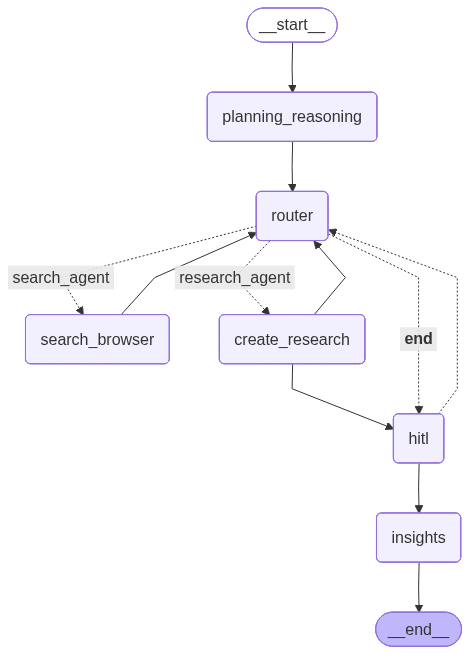

In [44]:
from IPython.display import Image

Image(agent.get_graph().draw_mermaid_png())

In [45]:
input_text = 'Nvidia RTX-5090'

In [46]:
insights = 'The Nvidia RTX 5090, a high-end graphics card, targets a broad demographic including tech enthusiasts, gamers, and professionals. Beyond general demanding applications, it is also specifically relevant for users engaged in design applications such as Solidworks, indicating its utility in professional CAD and rendering workflows.'

In [47]:


res = agent.invoke(
    {
        'messages': HumanMessage(content=input_text),
        'user_input': input_text,
        'insights': insights,
        'first_run': False,
        'approved': False,
        'counter': 0,
        'max_loop': 2,
    },
    config=config
)


Entering Planning Reasoning Node.......
With Insights..

Entering Router .....

Tool called: search_browser

Entering search browser tool.....

Entering Router .....

Tool called: create_research

Entering Research tool.....

Entering HITL.......

Entering Router .....

No tool called


In [48]:
for msg in res['messages']:
    msg.pretty_print()

================================ Human Message =================================

Nvidia RTX-5090
================================== Ai Message ==================================

The Plan is as follows : 1. Initial Search for "Nvidia RTX 5090" to determine its current status (official announcement, reliable leaks, or speculation). 2. Extract Key Specifications, Features, and Release Information from the search results. 3. Investigate Performance Expectations, Benchmarks, and Target Use Cases, expanding on the insights from previous runs. 4. Research Potential Pricing and Market Positioning of the RTX 5090. 5. Compile a Comprehensive Research Report using all gathered information.

The reasoning for them is as follows : The user is asking for information about the Nvidia RTX-5090. The previous insights provide a good starting point, indicating it's a high-end graphics card for various demographics and professional applications. To provide a comprehensive and up-to-date answer, I need t

In [49]:
res['content']

['18-45',
 'Everyone',
 'High-end PC gamers, content creators (video editors, 3D artists, animators), and professionals in AI development and scientific visualization.',
 'To provide a comprehensive overview of the Nvidia RTX 5090 based on current rumors and speculation, covering its status, specifications, performance, target audience, and market positioning.']

In [50]:
if res.get("__interrupt__"):
    print("Interrupted! Waiting for human input...")
    print(res["__interrupt__"])

    # Get human decision here
    user_decision = input("Enter your value: ")

Interrupted! Waiting for human input...
[Interrupt(value=["The user is asking for information about the Nvidia RTX-5090. The previous insights provide a good starting point, indicating it's a high-end graphics card for various demographics and professional applications. To provide a comprehensive and up-to-date answer, I need to gather more detailed information. My plan is to first perform a broad search to understand the current status of the RTX 5090 (e.g., officially announced, rumored, or speculative). This initial step is crucial as it will dictate the type and reliability of information I can find. Following this, I will focus on extracting specific technical specifications, any new features, and potential release details. Then, I will delve into performance expectations, benchmarks, and confirm its target use cases, building upon the existing insights. Understanding its potential pricing and market positioning will complete the financial and competitive landscape. Finally, all t

In [51]:
res2 = agent.invoke(Command(resume=user_decision), config=config)


Entering HITL.......
Human Feedback:   Approved

Entering HITL last time.....


In [52]:
for msg in res2['messages']:
    msg.pretty_print()

================================ Human Message =================================

Nvidia RTX-5090
================================== Ai Message ==================================

The Plan is as follows : 1. Initial Search for "Nvidia RTX 5090" to determine its current status (official announcement, reliable leaks, or speculation). 2. Extract Key Specifications, Features, and Release Information from the search results. 3. Investigate Performance Expectations, Benchmarks, and Target Use Cases, expanding on the insights from previous runs. 4. Research Potential Pricing and Market Positioning of the RTX 5090. 5. Compile a Comprehensive Research Report using all gathered information.

The reasoning for them is as follows : The user is asking for information about the Nvidia RTX-5090. The previous insights provide a good starting point, indicating it's a high-end graphics card for various demographics and professional applications. To provide a comprehensive and up-to-date answer, I need t

In [53]:
res2['insights']

"1. **Predictable Product Lifecycle & Hype Management:** High-end GPUs like the Nvidia RTX 5090 typically follow a well-established product cycle involving leaks, rumors, and official announcements. This speculative phase is a crucial part of market strategy to build anticipation and manage consumer expectations, underscoring the importance of discerning between confirmed facts and unverified information. 2. **Continuous Performance Escalation & Innovation:** The flagship GPU market is characterized by a relentless pursuit of technological advancement. Each new generation, exemplified by the RTX 5090, consistently pushes boundaries with new architectures, advanced memory technologies (e.g., GDDR7), increased core counts, and higher clock speeds, reflecting an ongoing drive for superior raw processing power and efficiency. 3. **Diversified High-End Market Targeting:** Premium GPUs are strategically designed to appeal to a broad, demanding audience beyond just enthusiast gamers. This inc